<a href="https://colab.research.google.com/github/DanieloSendi/Deep-Learning-Lab/blob/main/07_Unsupervised_Learning_Autoencoders_and_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unsupervised Learning - Autoencoders and GANs**

***
## **Autoencoders**
***

The key idea of image generation is to develop a low-dimensional latent space of representations (which naturally is a vector space) where any point can be mapped to a realistic-looking image. The module capable of realizing this mapping, taking as input a latent point and outputting an image (a grid of pixels), is called a generator (in the case of GANs) or a decoder (in the case of autoencoders). Once such a latent space has been developed, you can sample points from it, either deliberately or at random, and, by mapping them to image space, generate images that have never been seen before.

A classical image autoencoder takes an image, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the original image, via a decoder module (see figure 8.12). It’s then trained by using as target data the same images as the input images, meaning the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the code (the output of the encoder), you can get the autoencoder to learn more-or-less interesting latent representations of the data. Most commonly, you’ll constrain the code to be low-dimensional and sparse (mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

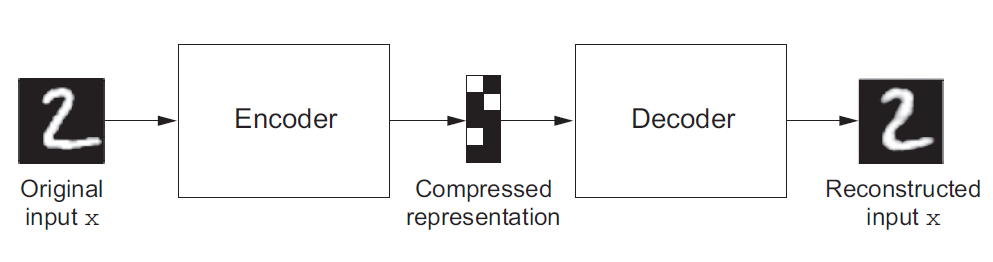

### Simple autoencoder

We'll start with a single fully-connected neural layer as an encoder and as a decoder.

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [2]:
# load MNIST data set
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


We will normalize all values between 0 and 1 and we will flatten the 28×28 images into vectors of size 784.

In [3]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

It is time to prepare the model itself. However, before we will do it let's notice that we won't use common models.Sequential() at the beginning. All neural networks introduced before have been implemented using the Sequential model, which makes the assumption that the network has exactly one input and exactly one output, and that it consists of a linear stack of layers. When this is not the case, we can use `Keras functional API` to better personalize it to our needs. In the functional API, you directly manipulate tensors, and you use layers as functions that take tensors and return tensors. Every layer is constructed like this:

*output_tensor = Layer(parameters)(input_tensor)*

By correct use of input and output variable names, we can connect them to one another. When we chain all layers together we use the Model function (with input and output variable names of the whole network as parameters) to create a complete model.

*model_name = **Model**(network_input_name, network_output_name)*

Our first autoencoder can be a good example of this:

In [4]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Now, let's prepare separate models for encoder and decoder:

In [5]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


Now let's train our autoencoder to reconstruct MNIST digits.

In [6]:
# configure the model to use a binary crossentropy loss and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

# As a starting point set epoch to 50, batch size to 256, shuffle data, and use x_test as a validation set.
autoencoder.fit(x_train, x_train,
                batch_size=256,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

# encode and decode some digits note that we take them from the test set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.3795 - val_loss: 0.1901
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1797 - val_loss: 0.1520
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1481 - val_loss: 0.1327
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1308 - val_loss: 0.1207
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1198 - val_loss: 0.1124
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1122 - val_loss: 0.1067
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1068 - val_loss: 0.1025
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1031 - val_loss: 0.0994
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1003 - val_loss: 0.0971
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0978 - val_loss: 0.0955
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0966 - val_loss: 0.0944
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

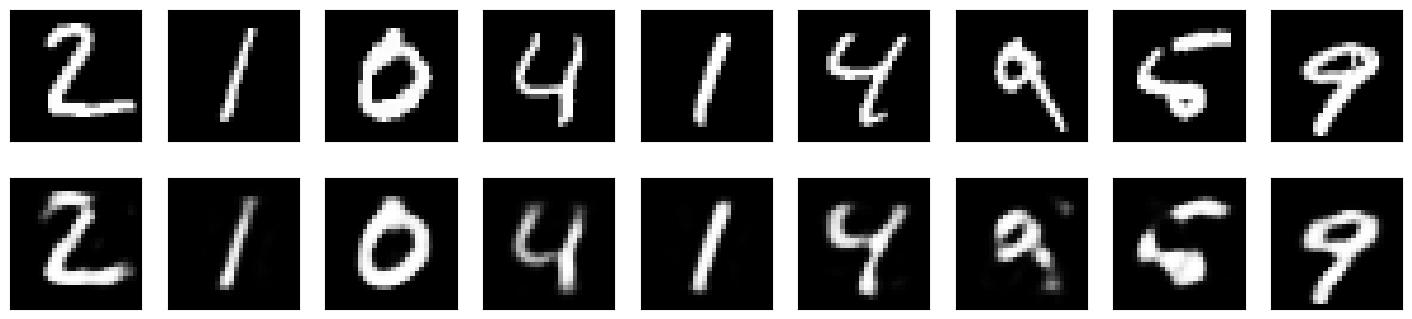

In [7]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

### Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders –they simply perform much better.

To train it, we will again use the original MNIST digits but with shape (samples, 28, 28, 1), and we will just normalize pixel values between 0 and 1.

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Now, let's prepare the model. The encoder will consist of a stack of Conv2D and MaxPooling2D layers (max-pooling being used for spatial down-sampling), while the decoder will consist of a stack of Conv2D and UpSampling2D layers.

In [9]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

# configure model to use a binary crossentropy loss, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

# Set epoch to 10, batch size to 128, shuffle data, and use x_test as a validation set.
autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_imgs = autoencoder.predict(x_test)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.3317 - val_loss: 0.1456
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1393 - val_loss: 0.1244
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1232 - val_loss: 0.1161
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1161 - val_loss: 0.1116
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1121 - val_loss: 0.1088
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1095 - val_loss: 0.1069
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1076 - val_loss: 0.1050
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1061 - val_loss: 0.1059
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1050 - val_loss: 0.1031
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1035 - val_loss: 0.1017
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1026 - val_loss: 0.1009
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/st

More examples of how to use autoenkoders can be found in this [blog](https://blog.keras.io/building-autoencoders-in-keras.html)

Let's take a look at the reconstructed digits:

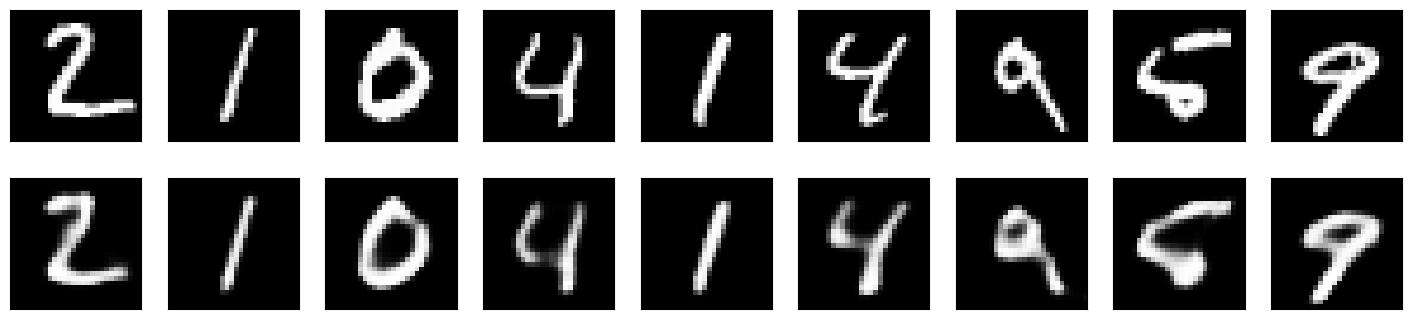

In [10]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***
## **GAN - Generative Adversarial Networks**
***

An intuitive way to understand GANs is to imagine a forger trying to create a fake Picasso painting. At first, the forger is pretty bad at the task. He mixes some of his fakes with authentic Picassos and shows them all to an art dealer. The art dealer makes an authenticity assessment for each painting and gives the forger feedback about what makes a Picasso look like a Picasso. The forger goes back to his studio to prepare some new fakes. As time goes on, the forger becomes increasingly competent at imitating the style of Picasso, and the art dealer becomes increasingly expert at spotting fakes. In the end, they have on their hands some excellent fake Picassos.

That’s what a GAN is: a forger network and an expert network, each being trained to best the other. As such, a GAN is made of two parts:

- Generator network — Takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image
- Discriminator network (or adversary) — Takes as input an image (real or synthetic), and predicts whether the image came from the training set or was created by the generator network.

The generator network is trained to be able to fool the discriminator network, and thus it evolves toward generating increasingly realistic images as training goes on: artificial images that look indistinguishable from real ones, to the extent that it’s impossible for the discriminator network to tell the two apart. Meanwhile, the discriminator is constantly adapting to the gradually improving capabilities of the generator, setting a high bar of realism for the generated images. Once training is over, the generator is capable of turning any point in its input space into a believable image.

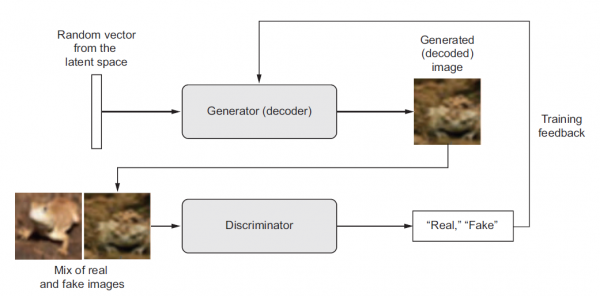



GANs are a form of neural network in which two sub-networks (the encoder and decoder) are trained on opposing loss functions: an encoder that is trained to produce data which is indiscernable from the true data, and a decoder that is trained to discern between the data and generated data.

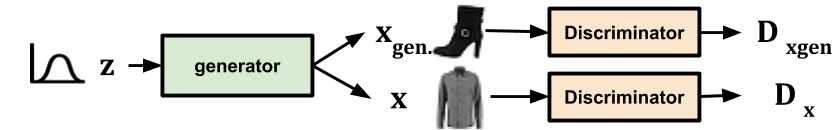

### Install packages

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import sys, subprocess

<ipython-input-11-40e648c21d8a>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [12]:
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

### Create a fashion-MNIST dataset

In [13]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [14]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Define the network as tf.keras.model object

In [15]:
class GAN(tf.keras.Model):
    """ a basic GAN class
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


### Define the network architecture

In [16]:
N_Z = 64

generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Create model

In [17]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

### Train model

In [18]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, 1, 1, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [19]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 49 | disc_loss: 0.9549607634544373 | gen_loss: 1.9628474712371826


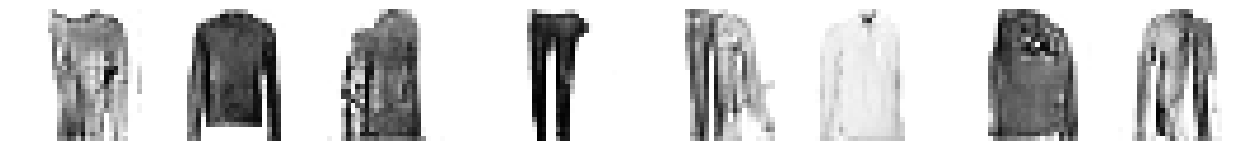

In [20]:
n_epochs = 50
for epoch in range(n_epochs):

    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)

    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)

GAN models are quite complex to implement and require more time and tuning to train them correctly. We won't code it during this lab. You can, however, try to run the ready script using Google Colab. In the webpage linked below, You will find a working code that You can analyze, edit, or even run by clicking the play button in each section. Training should be fast, as it uses Google's cloud GPUs. The only requirement is having a Google account.

[GAN on Google Colab](https://colab.research.google.com/drive/1VtRQnopJEgxRPyS76TK30bNYPX3r5abe)

**Sources**

[Stanford Lecture in PDF](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf)

[Stanford Lecture on YouTube](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=15)

[Book by F. Chollet: Deep learning with Python](https://www.manning.com/books/deep-learning-with-python)

[Tutorial by F. Chollet](https://www.manning.com/books/deep-learning-with-python)